years 2015-2060
var = [tasmax, tasmin, pr, sfcWind, rsds, hurs]
ens = r1i1p1f1 or r1i1p1f2
models = [ACCESS-ESM1-5, GFDL-CM4_gr2, GISS-E2-1-G, INM-CM4-8]

In [ ]:
import os
import time
import requests
from concurrent.futures import ThreadPoolExecutor
from urllib.parse import quote

# Define parameters
base_url = "https://ds.nccs.nasa.gov/thredds/ncss/grid/AMES/NEX/GDDP-CMIP6"
models = [
    "ACCESS-ESM1-5", 
    "GFDL-CM4_gr2", 
    "GISS-E2-1-G", 
    "INM-CM4-8"
    ]
variables = ["tasmax", "tasmin", "pr", "sfcWind", "rsds", "hurs"]
years = range(2015, 2061)

latitude = "6.2"
longitude = "357.67"
accept = "&&&accept=csv"

save_dir = r"C:\Users\Goblin\OneDrive\Desktop\ALMANAC-Inputs\CASEJ\SSP585"
os.makedirs(save_dir, exist_ok=True)

# Track failures
failed_downloads = []

# Download function with retries
def download_file(url_path):
    url, path = url_path
    for attempt in range(3):
        try:
            print(f"Downloading {os.path.basename(path)} (Attempt {attempt + 1})...")
            response = requests.get(url, timeout=60)
            response.raise_for_status()
            with open(path, "wb") as f:
                f.write(response.content)
            return  # Success
        except Exception as e:
            print(f"Error downloading {os.path.basename(path)}: {e}")
            if attempt < 2:
                time.sleep(5)
    print(f"Failed after 3 attempts: {os.path.basename(path)}")
    failed_downloads.append(os.path.basename(path))

# Build download tasks
tasks = []
for model in models:
    encoded_model = quote(model)  # handle models with underscores
    for var in variables:
        for year in years:
            # Try both ensemble possibilities to guess
            for ens_guess in ["r1i1p1f1", "r1i1p1f2"]:
                nc_filename = f"{var}_day_GFDL-CM4_ssp585_{ens_guess}_gr2_{year}.nc"
                # nc_filename = f"{var}_day_{model}_ssp585_{ens_guess}_gn_{year}.nc"
                url = (f"{base_url}/{encoded_model}/ssp585/{ens_guess}/{var}/{nc_filename}"
                       f"?var={var}&latitude={latitude}&longitude={longitude}"
                       f"&time_start={year}-01-01T12:00:00Z"
                       f"&time_end={year}-12-31T12:00:00Z"
                       f"{accept}")
                output_filename = f"{var}_day_{model}_ssp585_gn_{year}.csv"
                output_path = os.path.join(save_dir, output_filename)
                tasks.append((url, output_path))
                break  # Only need one ensemble

# Parallel download
with ThreadPoolExecutor(max_workers=10) as executor:
    executor.map(download_file, tasks)

# Report failures
if failed_downloads:
    print(f"\n{len(failed_downloads)} files failed to download:")
    for name in failed_downloads:
        print("-", name)
    with open("failed_downloads.txt", "w") as f:
        for name in failed_downloads:
            f.write(name + "\n")
else:
    print("\n✅ All files downloaded successfully!")



✅ All files downloaded successfully!


# Check output

In [6]:
import os
import glob
from collections import defaultdict

# Expected setup
models = ["ACCESS-ESM1-5", "GFDL-CM4_gr2", "GISS-E2-1-G", "INM-CM4-8"]
variables = ["tasmax", "tasmin", "pr", "sfcWind", "rsds", "hurs"]
years = range(2015, 2061)

save_dir = r"C:\Users\Goblin\OneDrive\Desktop\ALMANAC-Inputs\CASEJ\SSP585"

# Track missing
missing = []
missing_by_model = defaultdict(int)
missing_by_var = defaultdict(int)

for model in models:
    for var in variables:
        for year in years:
            pattern = f"{var}_day_{model}_ssp585_*{year}.csv"
            matches = glob.glob(os.path.join(save_dir, pattern))
            if not matches:
                missing.append((var, model, year))
                missing_by_model[model] += 1
                missing_by_var[var] += 1

# Report
if missing:
    print(f"\n{len(missing)} missing (var, model, year) combos:\n")
    for var, model, year in missing:
        print(f"- {var} {model} {year}")

    print("\nMissing counts by model:")
    for model, count in missing_by_model.items():
        print(f"- {model}: {count} files missing")

    print("\nMissing counts by variable:")
    for var, count in missing_by_var.items():
        print(f"- {var}: {count} files missing")
else:
    print("\n✅ All expected files are present!")



✅ All expected files are present!


# Convert for ALMANAC

In [7]:
import pandas as pd
import glob

# Function to format each row with the specified widths
def format_row(row):
    blank_column = '  '  # Blank column of width 2
    date_format = '{:4d}{:4d}{:4d}'.format(int(row['year']), int(row['month']), int(row['day']))
    formatted_values = [
        f'{row["rsds"]:6.1f}',  # 1 decimal place
        f'{row["tasmax"]:6.2f}',  # 2 decimal places
        f'{row["tasmin"]:6.2f}',  # 2 decimal places
        f'{row["pr"]:6.2f}',  # 2 decimal places
        f'{row["hurs"]:6.3f}',  # 3 decimal places
        f'{row["sfcwind"]:6.3f}'  # 3 decimal places
    ]
    data_format = ''.join(formatted_values)
    return f'{blank_column}{date_format}{data_format}'

In [21]:
# Define the path to the input files
dir = r'C:\Users\Goblin\OneDrive\Desktop\ALMANAC-Inputs\\'
models = ['gfdl', 'inm', 'giss', 'access']
variables = ['hurs', 'rsds', 'pr', 'sfcwind', 'tasmax', 'tasmin']
desired_order = ['rsds', 'tasmax', 'tasmin', 'pr', 'hurs', 'sfcwind']

# Initialize a dictionary to hold the combined DataFrames for each model
combined_dfs = {model: pd.DataFrame() for model in models}

# Loop through each model and variable
for model in models:
    print(f"Processing model: {model}")
    # Initialize a list to hold DataFrames for the current model
    model_dataframes = []
    
    for variable in variables:
        print(f"  Processing variable: {variable}")
        # Generate the file path pattern for the current model and variable
        file_pattern = f'{dir}CASEJ\\SSP585\\{variable}*{model}*'
        file_paths = sorted(glob.glob(file_pattern))
        
        # Initialize an empty list to hold the DataFrames for the current variable
        variable_dataframes = []
        
        # Loop through the file paths and read each file into a DataFrame
        for file in file_paths:
            df = pd.read_csv(file, header=0, parse_dates=True)
            df = df.iloc[:, [0, -1]]  # Select the first and last columns
            # print(df.head())  # Display the first few rows of the DataFrame for debugging
            df.set_index(df.columns[0], inplace=True)  # Set the first column as the index
            df.index.name = 'date'  # Set the index name to 'date'
            df.columns = [variable]  # Rename the column to the variable name
            variable_dataframes.append(df)
        
        # Concatenate all DataFrames for the current variable along the time axis (rows)
        if variable_dataframes:
            combined_variable_df = pd.concat(variable_dataframes, axis=0)
            
            # Convert the index to datetime
            combined_variable_df.index = pd.to_datetime(combined_variable_df.index, errors='coerce')
            # Normalize the date to remove the time (sets time to 00:00:00)
            combined_variable_df.index = combined_variable_df.index.normalize()

            model_dataframes.append(combined_variable_df)
    
    # Concatenate all variable DataFrames for the current model along the columns
    if model_dataframes:
        combined_model_df = pd.concat(model_dataframes, axis=1)
        
        # Reorder the columns
        combined_model_df = combined_model_df[desired_order]
        
        # # Convert the index to datetime
        # combined_model_df.index = pd.to_datetime(combined_model_df.index, errors='coerce')
        
        # Extract year, month, and day from the date index
        combined_model_df['year'] = combined_model_df.index.year
        combined_model_df['month'] = combined_model_df.index.month
        combined_model_df['day'] = combined_model_df.index.day
        
        # Optionally, drop the original date index
        combined_model_df.reset_index(drop=True, inplace=True)
        
        # Reorder columns to place year, month, and day at the beginning
        combined_model_df = combined_model_df[['year', 'month', 'day'] + desired_order]
        
        # Adjust units and values 
        combined_model_df['sfcwind'] *= 1.3
        combined_model_df['pr'] *= 86400  # Convert from kg m−2 s −1 to mm/day
        combined_model_df[['tasmax', 'tasmin']] -= 273.15  # Convert from K to C
        combined_model_df['rsds'] *= 0.0864  # Convert from W/m2 to MJ/m2
        
        # Format decimal places
        combined_model_df['rsds'] = combined_model_df['rsds'].round(1)  # 1 decimal place
        combined_model_df['tasmax'] = combined_model_df['tasmax'].round(2)  # 2 decimal places
        combined_model_df['tasmin'] = combined_model_df['tasmin'].round(2)  # 2 decimal places
        combined_model_df['pr'] = combined_model_df['pr'].round(2)  # 2 decimal places
        combined_model_df['hurs'] = combined_model_df['hurs'].round(3)  # 3 decimal places
        combined_model_df['sfcwind'] = combined_model_df['sfcwind'].round(3)  # 3 decimal places
        
        # Store the modified DataFrame
        combined_dfs[model] = combined_model_df
        
        # Format rows and save to file with fixed-width columns
        formatted_rows = combined_model_df.apply(format_row, axis=1)
        with open(f"{dir}CASEJ\\SSP585\\Final\\{model}.wth", 'w') as f:
            f.write('\n'.join(formatted_rows))

# Display the combined DataFrame for each model
for model, df in combined_dfs.items():
    print(f"Combined DataFrame for model {model}:")
    print(df)

Processing model: gfdl
  Processing variable: hurs
  Processing variable: rsds
  Processing variable: pr
  Processing variable: sfcwind
  Processing variable: tasmax
  Processing variable: tasmin
Processing model: inm
  Processing variable: hurs
  Processing variable: rsds
  Processing variable: pr
  Processing variable: sfcwind
  Processing variable: tasmax
  Processing variable: tasmin
Processing model: giss
  Processing variable: hurs
  Processing variable: rsds
  Processing variable: pr
  Processing variable: sfcwind
  Processing variable: tasmax
  Processing variable: tasmin
Processing model: access
  Processing variable: hurs
  Processing variable: rsds
  Processing variable: pr
  Processing variable: sfcwind
  Processing variable: tasmax
  Processing variable: tasmin
Combined DataFrame for model gfdl:
       year  month  day  rsds  tasmax  tasmin   pr    hurs  sfcwind
0      2015      1    1  21.3   30.73   21.87  0.0  72.292    4.429
1      2015      1    2  21.7   30.14   21.7

# Plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

hist = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Hist', header=0)
future = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Future', header=0)
obs = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Obs', header=0)

# Set 'Year' column as the index for all three DataFrames
hist.set_index('Year', inplace=True)
future.set_index('Year', inplace=True)
obs.set_index('Year', inplace=True)

# Multiply future and hist DataFrames by 1000
future *= 1000
hist *= 1000

future

,ACCESS,ACCESS-Low,GFDL,GFDL-low,GISS,GISS-Low,INM,INM-low
Year,,,,,,,,
2030,1640.0,910.0,1540.0,890.0,1640.0,900.0,1580.0,900.0
2031,1650.0,900.0,1570.0,890.0,1610.0,870.0,1600.0,890.0
2032,1630.0,880.0,1590.0,890.0,1610.0,850.0,1600.0,880.0
2033,1630.0,890.0,1590.0,890.0,1610.0,840.0,1610.0,890.0
2034,1630.0,890.0,1590.0,880.0,1600.0,830.0,1600.0,880.0
2035,1630.0,870.0,1590.0,880.0,1590.0,810.0,1600.0,880.0
2036,1620.0,860.0,1580.0,870.0,1600.0,810.0,1590.0,870.0
2037,1570.0,840.0,1570.0,870.0,1600.0,830.0,1580.0,860.0
2038,1570.0,830.0,1570.0,880.0,1590.0,830.0,1550.0,840.0


In [43]:
hist

,Water-limited,Low-input
Year,,
1980,1510.0,910.0
1981,1520.0,920.0
1982,1490.0,900.0
1983,1450.0,860.0
1984,1450.0,840.0
1985,1470.0,850.0
1986,1460.0,840.0
1987,1440.0,820.0
1988,1400.0,800.0


In [30]:
future_avg = future.mean()
future_avg

ACCESS        1552.000000
ACCESS-Low     825.333333
GFDL          1493.666667
GFDL-low       831.666667
GISS          1519.333333
GISS-Low       773.333333
INM           1533.000000
INM-low        829.000000
dtype: float64

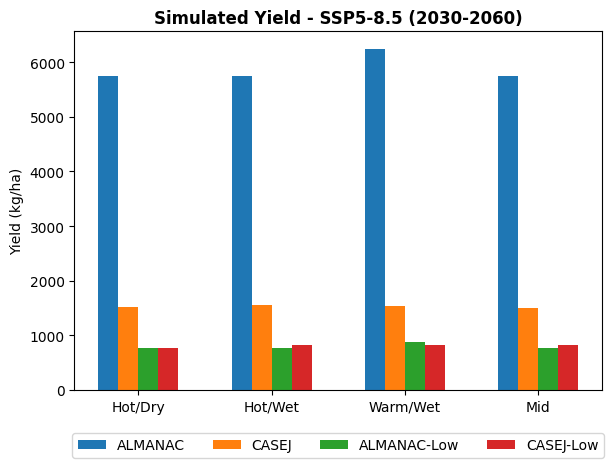

In [ ]:
# Define model -> category mapping
model_category = {
    'GISS': 'Hot/Dry',
    'GISS-Low': 'Hot/Dry',
    'ACCESS': 'Hot/Wet',
    'ACCESS-Low': 'Hot/Wet',
    'INM': 'Warm/Wet',
    'INM-low': 'Warm/Wet',
    'GFDL': 'Mid',
    'GFDL-low': 'Mid',
}

# Calculate average values
avg_values = future.mean()

# Organize by group
grouped = {'Hot/Dry': [], 'Hot/Wet': [], 'Warm/Wet': [], 'Mid': []}

# CASEJ values (just numbers here)
casej_values = {
    'Hot/Dry': [5750, 775],   # [CASEJ, CASEJ-low]
    'Hot/Wet': [5750, 775],
    'Warm/Wet': [6250, 875],
    'Mid': [5750, 775],
}

# Update grouped dictionary
for cat in grouped:
    grouped[cat].extend(casej_values[cat])


for model, category in model_category.items():
    grouped[category].append(avg_values[model])

# Make plot
categories = list(grouped.keys())
default = [grouped[cat][0] for cat in categories]
low = [grouped[cat][1] for cat in categories]
casej = [grouped[cat][2] for cat in categories]
casej_low = [grouped[cat][3] for cat in categories]

x = range(len(categories))
width = 0.15

fig, ax = plt.subplots()
ax.bar([i - 1.5*width for i in x], default, width, label='ALMANAC')
ax.bar([i - 0.5*width for i in x], casej, width, label='CASEJ')
ax.bar([i + 0.5*width for i in x], low, width, label='ALMANAC-Low')
ax.bar([i + 1.5*width for i in x], casej_low, width, label='CASEJ-Low')

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Yield (kg/ha)')
ax.set_title('Simulated Yield - SSP5-8.5 (2030-2060)', fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.tight_layout()
plt.show()

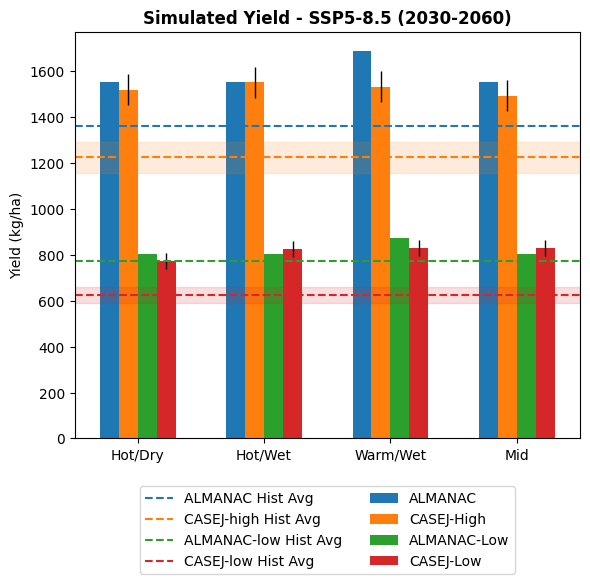

In [5]:
# Define model -> category mapping
model_category = {
    'GISS': 'Hot/Dry',
    'GISS-Low': 'Hot/Dry',
    'ACCESS': 'Hot/Wet',
    'ACCESS-Low': 'Hot/Wet',
    'INM': 'Warm/Wet',
    'INM-low': 'Warm/Wet',
    'GFDL': 'Mid',
    'GFDL-low': 'Mid',
}

# Calculate average values
avg_values = future.mean()

# Organize by group
grouped = {'Hot/Dry': [], 'Hot/Wet': [], 'Warm/Wet': [], 'Mid': []}

# # CASEJ values 
# casej_values = {
#     'Hot/Dry': [1552.5, 775],   # [CASEJ-high, CASEJ-low]
#     'Hot/Wet': [1552.5, 775],
#     'Warm/Wet': [1687.5, 875],
#     'Mid': [1552.5, 775],
# }

# CASEJ values 
casej_values = {
    'Hot/Dry': [5750*(1-0.73), 5750*(1-0.86)],   # [CASEJ-high, CASEJ-low]
    'Hot/Wet': [5750*(1-0.73), 5750*(1-0.86)],
    'Warm/Wet': [6250*(1-0.73), 6250*(1-0.86)],
    'Mid': [5750*(1-0.73), 5750*(1-0.86)],
}

# Update grouped dictionary
for cat in grouped:
    grouped[cat].extend(casej_values[cat])


for model, category in model_category.items():
    grouped[category].append(avg_values[model])

# Make plot
categories = list(grouped.keys())
default = [grouped[cat][0] for cat in categories]
low = [grouped[cat][1] for cat in categories]
casej = [grouped[cat][2] for cat in categories]
casej_low = [grouped[cat][3] for cat in categories]

x = range(len(categories))
width = 0.15

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-0.5, len(categories) - 0.5)

ax.bar([i - 1.5*width for i in x], default, width, label='ALMANAC')
ax.bar([i - 0.5*width for i in x], casej, width, label='CASEJ-High', yerr = 250*0.27, error_kw={'linewidth': 1})
ax.bar([i + 0.5*width for i in x], low, width, label='ALMANAC-Low')
ax.bar([i + 1.5*width for i in x], casej_low, width, label='CASEJ-Low', yerr = 250*0.14, error_kw={'linewidth': 1})

gmfd_hist_avg = hist['Water-limited'].mean()
gmfd_low_hist_avg = hist['Low-input'].mean()
# casej_hist_avg = 4750  # Enter manually
casej_low_hist_avg = 625  # Enter manually
casej_high_hist_avg = 1225  # Enter manually

ax.axhline(gmfd_hist_avg, color='tab:blue', linestyle='--', label='ALMANAC Hist Avg')
ax.axhline(casej_high_hist_avg, color='tab:orange', linestyle='--', label='CASEJ-high Hist Avg')
ax.axhline(gmfd_low_hist_avg, color='tab:green', linestyle='--', label='ALMANAC-low Hist Avg')
ax.axhline(casej_low_hist_avg, color='tab:red', linestyle='--', label='CASEJ-low Hist Avg')

ax.fill_between(
    [ax.get_xlim()[0], ax.get_xlim()[1]],
    casej_high_hist_avg - 250*0.27,
    casej_high_hist_avg + 250*0.27,
    color='tab:orange',
    alpha=0.15
)
ax.fill_between(
    [ax.get_xlim()[0], ax.get_xlim()[1]],
    casej_low_hist_avg - 250*0.14,
    casej_low_hist_avg + 250*0.14,
    color='tab:red',
    alpha=0.15
)

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Yield (kg/ha)')
ax.set_title('Simulated Yield - SSP5-8.5 (2030-2060)', fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()

In [ ]:
# fig.set_size_inches(3.28, 3.24)  # width, height in inches
fig.savefig(r"C:\Users\Goblin\OneDrive\Pictures\Cocoa chapter\Figure 5.png", dpi=300, bbox_inches='tight')

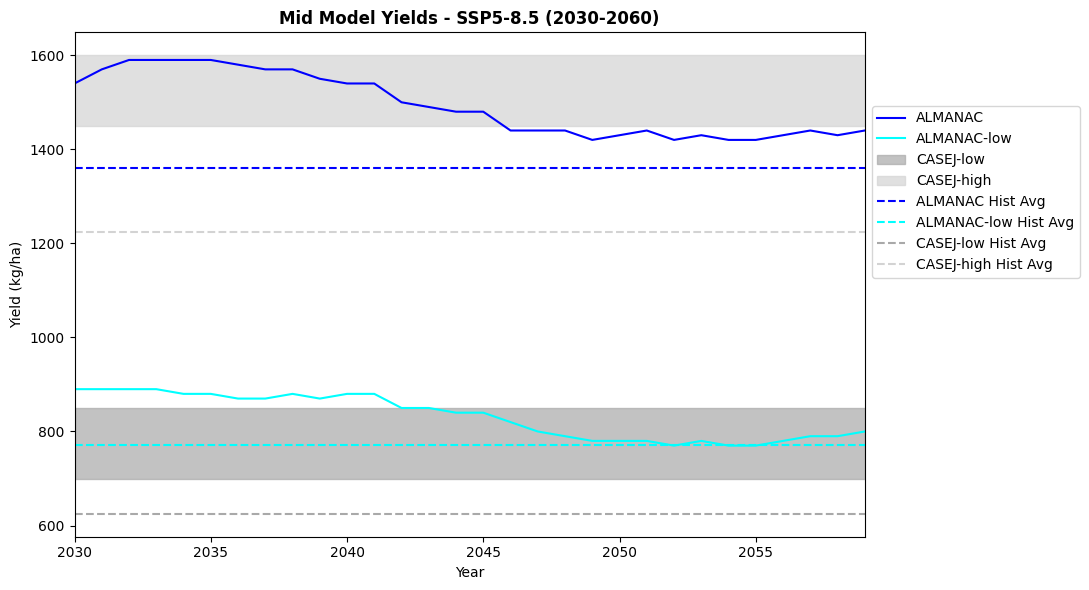

In [7]:
fig, ax = plt.subplots(figsize=(11, 6))

# Plot the mid models from future
ax.plot(future.index, future['GFDL'], label='ALMANAC', color='blue')
ax.plot(future.index, future['GFDL-low'], label='ALMANAC-low', color='cyan')

# CASEJ center values
casej_center = 5750   # CASEJ Mid
casej_low_center = 775  # CASEJ-low Mid
casej_high_center = 1525  # CASEJ High

# Shaded areas
# ax.fill_between(future.index, casej_center - 250, casej_center + 250, 
#                 color='gray', alpha=0.3, label='CASEJ')
ax.fill_between(future.index, casej_low_center - 75, casej_low_center + 75, 
                color='darkgray', alpha=0.7, label='CASEJ-low')
ax.fill_between(future.index, casej_high_center - 75, casej_high_center + 75,
                color='lightgray', alpha=0.7, label='CASEJ-high')

# Calculate historical averages
gmfd_hist_avg = hist['Water-limited'].mean()
gmfd_low_hist_avg = hist['Low-input'].mean()
# casej_hist_avg = 4750  # Enter manually
casej_low_hist_avg = 625  # Enter manually
casej_high_hist_avg = 1225  # Enter manually

# Add horizontal dashed lines
ax.axhline(gmfd_hist_avg, color='blue', linestyle='--', label='ALMANAC Hist Avg')
ax.axhline(gmfd_low_hist_avg, color='cyan', linestyle='--', label='ALMANAC-low Hist Avg')
# ax.axhline(casej_hist_avg, color='black', linestyle='--', label='CASEJ Hist Avg')
ax.axhline(casej_low_hist_avg, color='darkgray', linestyle='--', label='CASEJ-low Hist Avg')
ax.axhline(casej_high_hist_avg, color='lightgray', linestyle='--', label='CASEJ-high Hist Avg')

ax.set_ylabel('Yield (kg/ha)')
ax.set_xlabel('Year')
ax.set_title('Mid Model Yields - SSP5-8.5 (2030-2060)', fontweight='bold')
ax.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(future.index[0], future.index[-1])
plt.tight_layout()
plt.show()


In [ ]:
fig.savefig(r"C:\Users\Goblin\OneDrive\Pictures\Cocoa chapter\Figure 7.png", dpi=300, bbox_inches='tight')

hist = 4750 +/- 250
hist-low = 625 +/- 75
hist-high = 1225 +/- 75

In [65]:
obs = obs.loc[1980:2010]
obs

,Value,Flag Description
Year,,
1980,231.0,Estimated value
1981,205.4,Estimated value
1982,225.0,Estimated value
1983,210.1,Estimated value
1984,208.4,Estimated value
1985,216.0,Estimated value
1986,248.2,Official figure
1987,254.5,Official figure
1988,342.6,Official figure


The average reported value in each study and the range of values mentioned or calculated. some range over time only, some range time and space. These do not represent the same time period but yields have not changed much in Ghana.

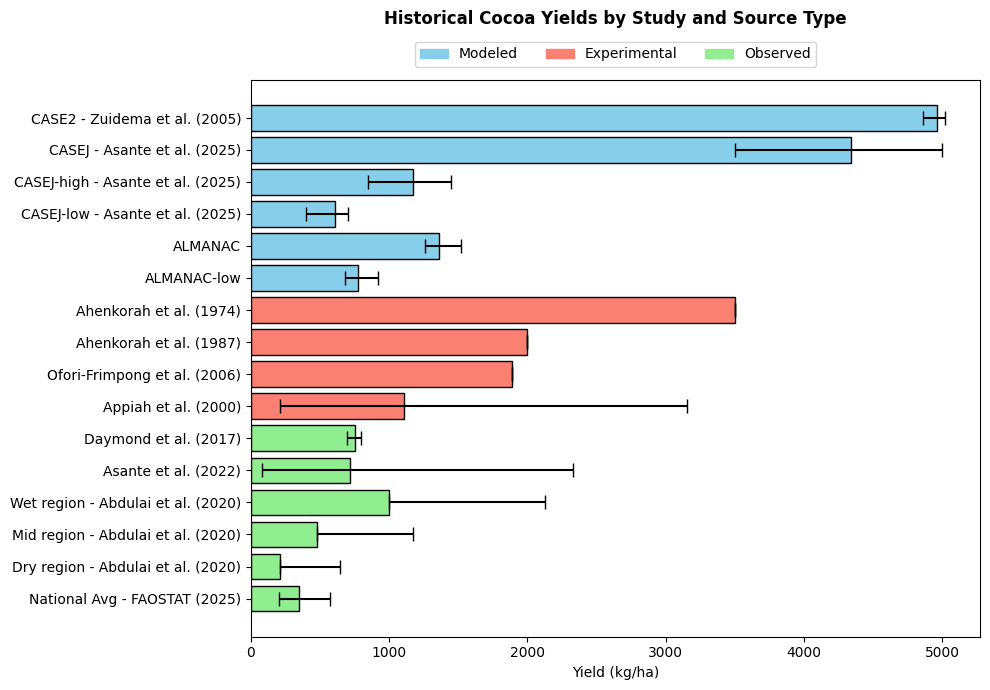

In [9]:
# Organize data
modeled = {
    'CASE2 - Zuidema et al. (2005)': 4965.33,
    'CASEJ - Asante et al. (2025)': 4342.86,
    'CASEJ-high - Asante et al. (2025)': 1173,
    'CASEJ-low - Asante et al. (2025)': 608,
    'ALMANAC': hist['Water-limited'].mean(),
    'ALMANAC-low': hist['Low-input'].mean(),
}

experimental = {
    
    'Ahenkorah et al. (1974)': 3500,
    'Ahenkorah et al. (1987)': 2000,
    'Ofori-Frimpong et al. (2006)': 1891.3,
    'Appiah et al. (2000)': 1105,
}

observed = {
    'Daymond et al. (2017)': 749.25,
    'Asante et al. (2022)': 717,
    'Wet region - Abdulai et al. (2020)': 999,
    'Mid region - Abdulai et al. (2020)': 477,
    'Dry region - Abdulai et al. (2020)': 211,
    'National Avg - FAOSTAT (2025)': obs['Value'].mean(),
}

# Errors are (lower, upper). Use 0 if one side is missing.
error_dict = {
    'CASE2 - Zuidema et al. (2005)': (105.33, 57.67),
    'CASEJ - Asante et al. (2025)': (843, 657),
    'CASEJ-high - Asante et al. (2025)': (323, 277),
    'CASEJ-low - Asante et al. (2025)': (208, 92),
    'Wet region - Abdulai et al. (2020)': (0, 1126),
    'Mid region - Abdulai et al. (2020)': (0, 697),
    'Dry region - Abdulai et al. (2020)': (0, 434),
    'Daymond et al. (2017)': (52.25, 44.75),
    'Asante et al. (2022)': (639, 1614),
    'National Avg - FAOSTAT (2025)': (obs['Value'].mean() - obs['Value'].min(), obs['Value'].max() - obs['Value'].mean()),
    'ALMANAC': (hist['Water-limited'].mean() - hist['Water-limited'].min(), hist['Water-limited'].max() - hist['Water-limited'].mean()),
    'ALMANAC-low': (hist['Low-input'].mean() - hist['Low-input'].min(), hist['Low-input'].max() - hist['Low-input'].mean()),
    'Appiah et al. (2000)': (893.84, 2051.22),
}

# Combine for plotting
all_data = [(label, value, 'Modeled') for label, value in modeled.items()] + \
           [(label, value, 'Experimental') for label, value in experimental.items()] + \
           [(label, value, 'Observed') for label, value in observed.items()]

# Sort optional
all_data.reverse()  # so bars go top-down in desired order

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
labels = [item[0] for item in all_data]
values = [item[1] for item in all_data]
groups = [item[2] for item in all_data]

color_map = {'Modeled': 'skyblue', 'Experimental': 'salmon', 'Observed': 'lightgreen'}
colors = [color_map[g] for g in groups]

y_pos = range(len(labels))

# Create asymmetric error bars: lower_errors, upper_errors
lower_errors = []
upper_errors = []

for label in labels:
    if label in error_dict:
        low, up = error_dict[label]
    else:
        low, up = 0, 0
    lower_errors.append(low)
    upper_errors.append(up)

# Plot bars with error bars
ax.barh(y_pos, values, xerr=[lower_errors, upper_errors],
        color=colors, edgecolor='black', capsize=5)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Yield (kg/ha)')
ax.set_title('Historical Cocoa Yields by Study and Source Type', fontweight='bold', pad=40)

# Legend
from matplotlib.patches import Patch
legend_patches = [Patch(color=color_map[g], label=g) for g in color_map]
ax.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 1.01), ncol=3)

plt.tight_layout()
plt.show()


In [10]:
fig.savefig(r"C:\Users\Goblin\OneDrive\Pictures\Cocoa chapter\Figure 4.png", dpi=300, bbox_inches='tight')

## CO2 

In [11]:
import pandas as pd

# hist = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Hist', header=0)
# future = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Future', header=0)
# obs = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Obs', header=0)
no_co2 = pd.read_excel(r"C:\Users\Goblin\OneDrive\Documents\CASEJ project.xlsx", sheet_name='Future (no CO2)', header=0)

# Set 'Year' column as the index for all three DataFrames
no_co2.set_index('Year', inplace=True)

# Multiply future and hist DataFrames by 1000
no_co2 *= 1000

no_co2

,ACCESS,ACCESS-Low,GFDL,GFDL-low,GISS,GISS-Low,INM,INM-low
Year,,,,,,,,
2030,1550.0,890.0,1480.0,860.0,1550.0,890.0,1500.0,870.0
2031,1560.0,900.0,1520.0,880.0,1520.0,870.0,1510.0,880.0
2032,1540.0,890.0,1530.0,890.0,1510.0,860.0,1520.0,890.0
2033,1560.0,900.0,1530.0,890.0,1510.0,850.0,1530.0,900.0
2034,1560.0,900.0,1530.0,890.0,1500.0,840.0,1530.0,900.0
2035,1570.0,880.0,1540.0,890.0,1490.0,810.0,1530.0,900.0
2036,1560.0,870.0,1530.0,880.0,1510.0,820.0,1520.0,890.0
2037,1510.0,840.0,1530.0,870.0,1530.0,830.0,1500.0,870.0
2038,1520.0,840.0,1530.0,880.0,1520.0,830.0,1480.0,850.0


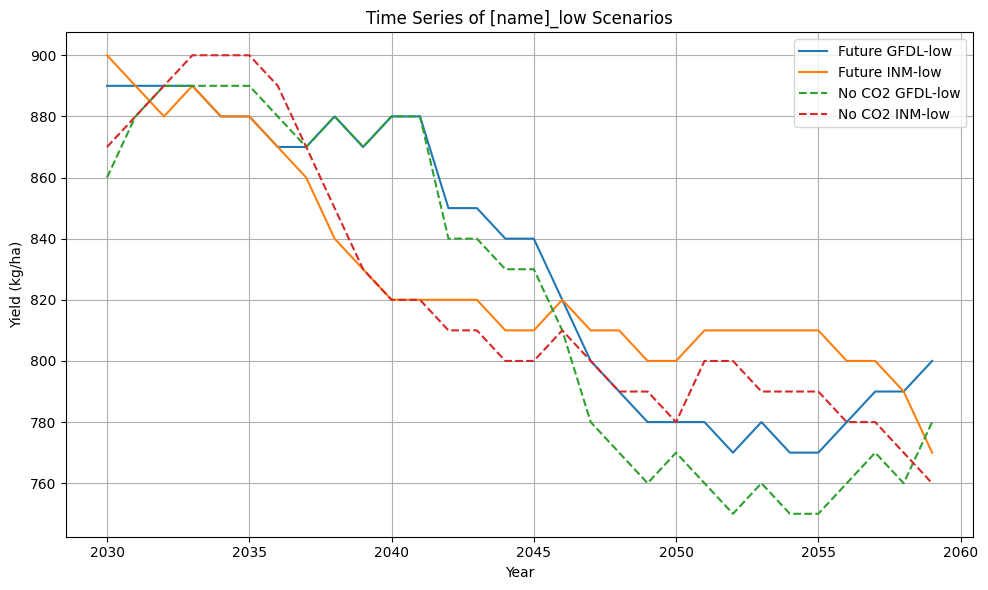

In [4]:
import matplotlib.pyplot as plt

# Select only the [name]_low scenarios
future_low = future.filter(like='low', axis=1)
no_co2_low = no_co2.filter(like='low', axis=1)

# Plot the time series
plt.figure(figsize=(10, 6))

# Plot future_low
for column in future_low.columns:
    plt.plot(future_low.index, future_low[column], label=f'Future {column}', linestyle='-')

# Plot no_co2_low
for column in no_co2_low.columns:
    plt.plot(no_co2_low.index, no_co2_low[column], label=f'No CO2 {column}', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Yield (kg/ha)')
plt.title('Time Series of [name]_low Scenarios')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\Goblin\AppData\Local\Temp\ipykernel_33456\627512935.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(regular_cols))  # color per scenario


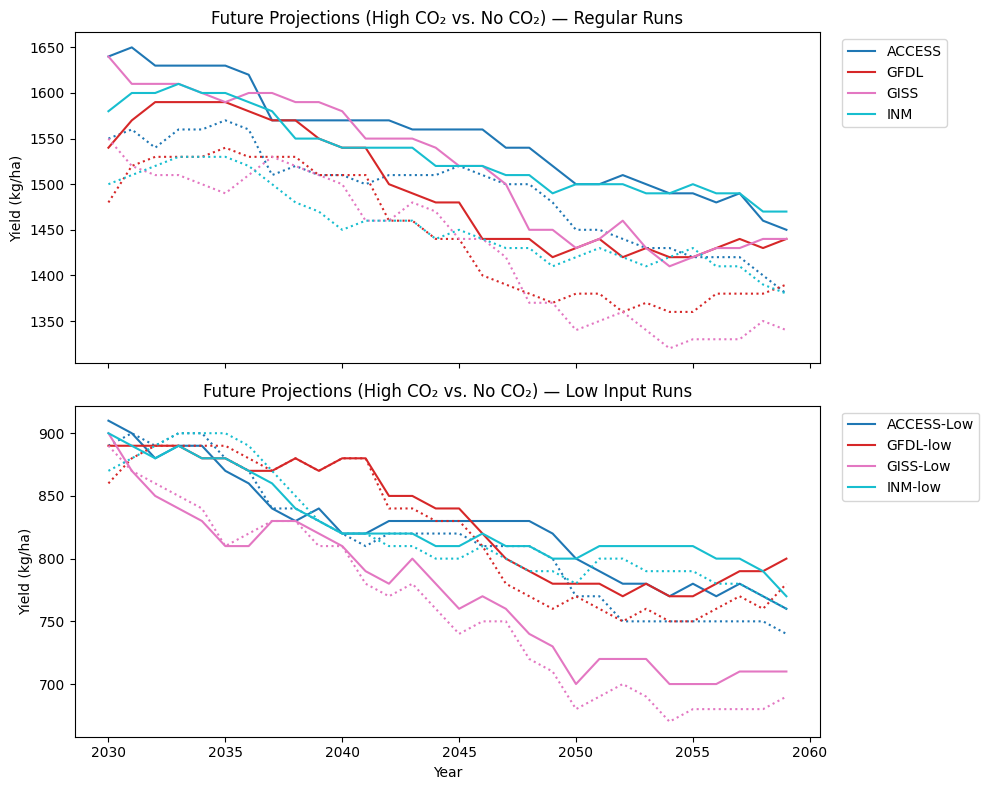

In [5]:
# Split columns into regular and low (case-insensitive)
regular_cols = [col for col in future.columns if 'low' not in col.lower()]
low_cols = [col for col in future.columns if 'low' in col.lower()]

# Set up colors
import matplotlib.cm as cm
colors = cm.get_cmap('tab10', len(regular_cols))  # color per scenario

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Regular runs subplot ---
for i, col in enumerate(regular_cols):
    axes[0].plot(future.index, future[col], label=col, color=colors(i))
    axes[0].plot(no_co2.index, no_co2[col], linestyle='dotted', color=colors(i))

axes[0].set_title('Future Projections (High CO₂ vs. No CO₂) — Regular Runs')
axes[0].set_ylabel('Yield (kg/ha)')
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# --- Low runs subplot ---
for i, col in enumerate(low_cols):
    axes[1].plot(future.index, future[col], label=col, color=colors(i))
    axes[1].plot(no_co2.index, no_co2[col], linestyle='dotted', color=colors(i))

axes[1].set_title('Future Projections (High CO₂ vs. No CO₂) — Low Input Runs')
axes[1].set_ylabel('Yield (kg/ha)')
axes[1].set_xlabel('Year')
axes[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()


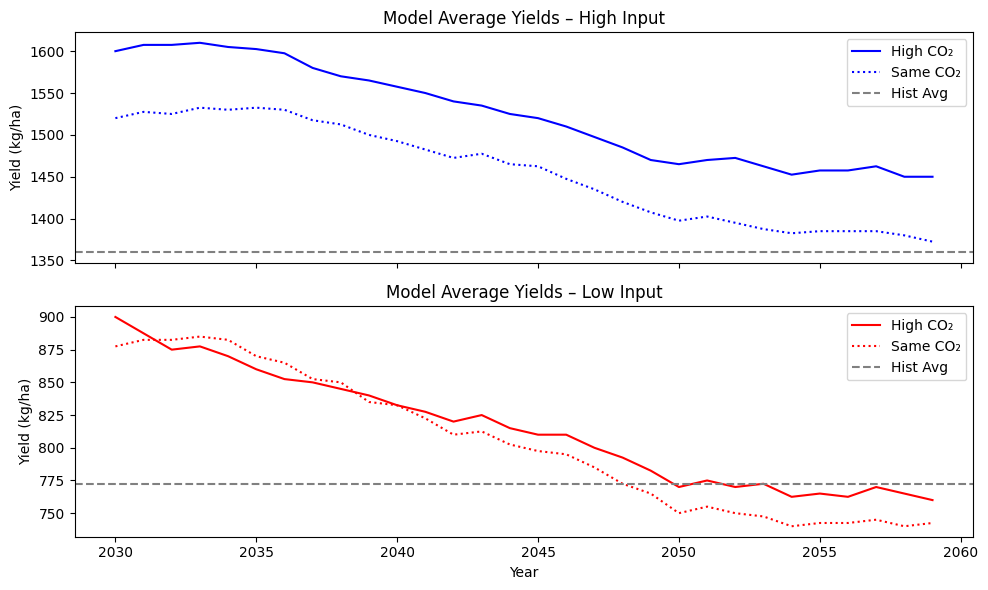

In [12]:
import matplotlib.pyplot as plt

# Split columns
regular_cols = [col for col in future.columns if 'low' not in col.lower()]
low_cols = [col for col in future.columns if 'low' in col.lower()]

# Calculate means
regular_future_mean = future[regular_cols].mean(axis=1)
regular_no_co2_mean = no_co2[regular_cols].mean(axis=1)

low_future_mean = future[low_cols].mean(axis=1)
low_no_co2_mean = no_co2[low_cols].mean(axis=1)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Regular subplot
axes[0].plot(future.index, regular_future_mean, label='High CO₂', color='blue')
axes[0].plot(no_co2.index, regular_no_co2_mean, label='Same CO₂', color='blue', linestyle='dotted')
axes[0].axhline(gmfd_hist_avg, color='gray', linestyle='--', label='Hist Avg')
axes[0].set_title('Model Average Yields – High Input')
axes[0].set_ylabel('Yield (kg/ha)')
axes[0].legend()

# Low subplot
axes[1].plot(future.index, low_future_mean, label='High CO₂', color='red')
axes[1].plot(no_co2.index, low_no_co2_mean, label='Same CO₂', color='red', linestyle='dotted')
axes[1].axhline(gmfd_low_hist_avg, color='gray', linestyle='--', label='Hist Avg')
axes[1].set_title('Model Average Yields – Low Input')
axes[1].set_ylabel('Yield (kg/ha)')
axes[1].set_xlabel('Year')
axes[1].legend()


# ax.axhline(casej_low_hist_avg, color='darkgray', linestyle='--', label='CASEJ-low Hist Avg')
# ax.axhline(casej_high_hist_avg, color='lightgray', linestyle='--', label='CASEJ-high Hist Avg')

plt.tight_layout()
plt.show()


In [13]:
fig.savefig(r"C:\Users\Goblin\OneDrive\Pictures\Cocoa chapter\Figure 6.png", dpi=300, bbox_inches='tight')

In [14]:
# Overall means
reg_future_avg = future[regular_cols].mean().mean()
reg_no_co2_avg = no_co2[regular_cols].mean().mean()
low_future_avg = future[low_cols].mean().mean()
low_no_co2_avg = no_co2[low_cols].mean().mean()

# Percent differences
reg_pct_diff = 100 * (reg_future_avg - reg_no_co2_avg) / reg_no_co2_avg
low_pct_diff = 100 * (low_future_avg - low_no_co2_avg) / low_no_co2_avg

print(f"Regular runs: {reg_pct_diff:.2f}% higher with CO₂")
print(f"Low-input runs: {low_pct_diff:.2f}% higher with CO₂")


Regular runs: 4.75% higher with CO₂
Low-input runs: 1.29% higher with CO₂


In [15]:
print(f"Regular runs: {reg_future_avg:.2f} with CO₂, {reg_no_co2_avg:.2f} without CO₂")
print(f"Low-input runs: {low_future_avg:.2f} with CO₂, {low_no_co2_avg:.2f} without CO₂")

Regular runs: 1524.50 with CO₂, 1455.42 without CO₂
Low-input runs: 814.83 with CO₂, 804.42 without CO₂
